In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage.filters import gaussian
import itertools
import cv2

In [2]:
#Loading images
path_mac = "/Users/pritam/Desktop/DIP/Assignment 2/DIP2025/images/images"
path_window = 'DIP2025\\Assignment2\\images'
image_folder_path = Path(path_window)
all_images = []
for image_path in image_folder_path.glob('*'):
    if image_path.is_file():
        try:
            with Image.open(image_path) as img:
                all_images.append(img.copy())
            print(f"Loaded image: {image_path.name}")
        except IOError:
            print(f"Could not load image: {image_path.name}")
print(f"\nSuccessfully loaded {len(all_images)} images.")


Loaded image: flowers.png
Loaded image: moon_noisy.png
Loaded image: sharp.png
Loaded image: study.png

Successfully loaded 4 images.


In [3]:
flowers, moon_noisy, sharp, study = all_images

In [9]:
flowers_array = np.array(moon_noisy)
flowers_array.shape

(300, 300, 3)

In [23]:
class FilteringAndBinarization:
    def __init__(self, m):
        self.m = m

    def box_filter(self):
        box = np.ones((self.m, self.m), dtype=float)
        return box / (self.m * self.m)

    def convolve(self, image, kernel):
        if isinstance(image, Image.Image):
            image = image.convert('L')
            image = np.array(image)
        elif image.ndim == 3:  # RGB as np array
            image = np.mean(image, axis=2).astype(np.float32) # Simply taking the mean of values of channels

        conv_image = cv2.filter2D(image, -1, kernel)
        return conv_image.astype(np.float32)

    def histogram_compute(self, img):
        if isinstance(img, Image.Image):
            img = img.convert('L')
            img = np.array(img)
        elif img.ndim == 3:  # RGB as np array
            img = np.mean(img, axis=2).astype(np.uint8) 

        gray_img = img.ravel()
        mn = len(gray_img)
        hist, _ = np.histogram(gray_img, bins=256, range=(0, 256))
        return hist / mn

    def otsu_binarization(self, norm_histogram, threshold):
        class0_prob = np.sum(norm_histogram[:threshold+1]) # Calculate probability of class 0 (pixels <= threshold)
        class1_prob = 1 - class0_prob         # Calculate probability of class 1 (pixels > threshold)
        
        if class0_prob > 0:
            class0_mean = np.sum(np.arange(0, threshold+1) * norm_histogram[:threshold+1]) / class0_prob # Calculate mean intensity of class 0
        else:
            class0_mean = 0
        if class1_prob > 0:
            class1_mean = np.sum(np.arange(threshold+1, 256) * norm_histogram[threshold+1:]) / class1_prob # Calculate mean intensity of class 1
        else:
            class1_mean = 0

        sigma_B_square = class0_prob * class1_prob * (class1_mean - class0_mean) ** 2 # Compute between-class variance (Otsu's criterion)
        global_mean = class0_prob * class0_mean + class1_prob * class1_mean  # Compute global mean intensity
        global_variance = np.sum((np.arange(0, 256) - global_mean) ** 2 * norm_histogram) # Compute global variance of all pixels
        return global_variance - sigma_B_square # Return within-class variance (for minimization)

    def otsu_threshold(self, img):
        # Compute normalized histogram
        norm_hist = self.histogram_compute(img)
        # Minimize within-class variance
        variances = [self.otsu_binarization(norm_hist, t) for t in range(256)]
        return np.argmin(variances)


In [41]:
kernel_sizes = [5,29,129]
within_class_variances = []
OtsuThresholds = []
bin_images = []
hists = []
convolved_images = [moon_noisy]

In [42]:
for m in kernel_sizes:
    q1 = FilteringAndBinarization(m)
    kernel = q1.box_filter()
    conv_img = q1.convolve(moon_noisy, kernel)
    convolved_images.append(conv_img.copy())
    # Store raw intensities (for plotting histograms later)
    hists.append(conv_img.ravel())
    
    # Normalized histogram
    norm_hist = q1.histogram_compute(conv_img)
    
    # Otsu threshold
    threshold = q1.otsu_threshold(conv_img)
    OtsuThresholds.append(threshold)
    
    # Within-class variance
    within_class_variances.append(q1.otsu_binarization(norm_hist, threshold=threshold))
    # Binarization
    binary_img = conv_img.copy()
    binary_img = (binary_img > threshold).astype(np.uint8) * 255
    bin_images.append(binary_img)


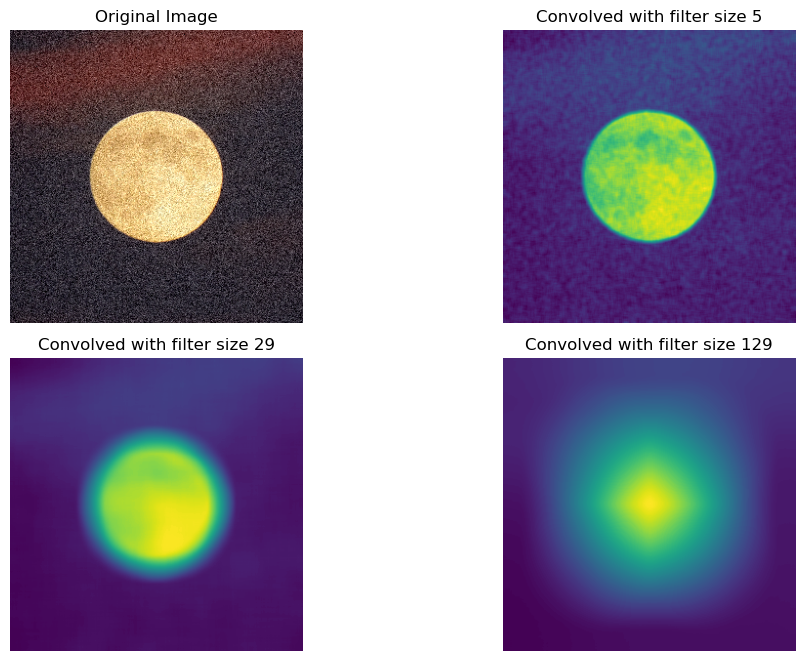

In [43]:
plt.figure(figsize=(10, 10))
titles = ["Original Image"] + [f"Convolved with filter size {m}" for m in kernel_sizes]

for i, img in enumerate(convolved_images):
    plt.subplot(3, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(titles[i])

plt.tight_layout()
plt.show()


In [44]:
for i in range(len(within_class_variances)):
    print(f"Within class variance for kernel size {kernel_sizes[i]} is {within_class_variances[i]:0.2f}")

Within class variance for kernel size 5 is 169.62
Within class variance for kernel size 29 is 287.54
Within class variance for kernel size 129 is 270.51


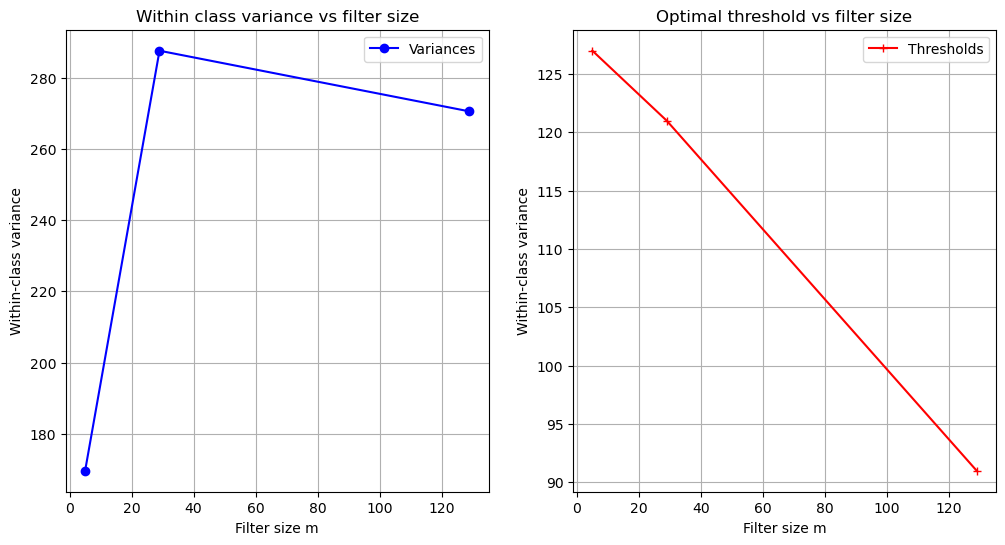

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(kernel_sizes, within_class_variances, marker = 'o', color= 'b', label='Variances')
plt.legend()
plt.title("Within class variance vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Within-class variance")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(kernel_sizes, OtsuThresholds, marker = '+', color= 'r', label = 'Thresholds')
plt.legend()
plt.title("Optimal threshold vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Within-class variance")
plt.grid(True)
plt.show()

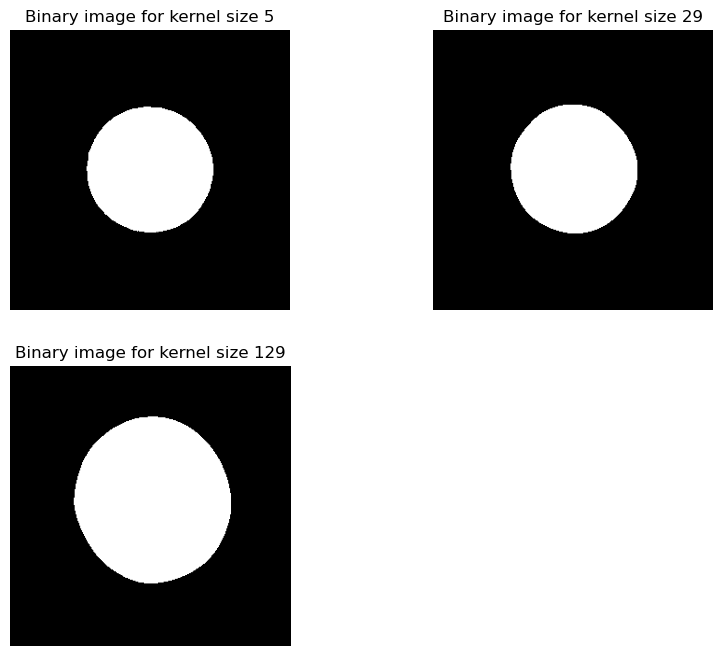

In [48]:
plt.figure(figsize=(10,8))
for i, bin_img in enumerate(bin_images):
    plt.subplot(2,2,i+1)
    plt.imshow(bin_img, cmap='gray')
    # plt.tight_layout()
    plt.title(f"Binary image for kernel size {kernel_sizes[i]}")
    plt.axis('off')
plt.show()

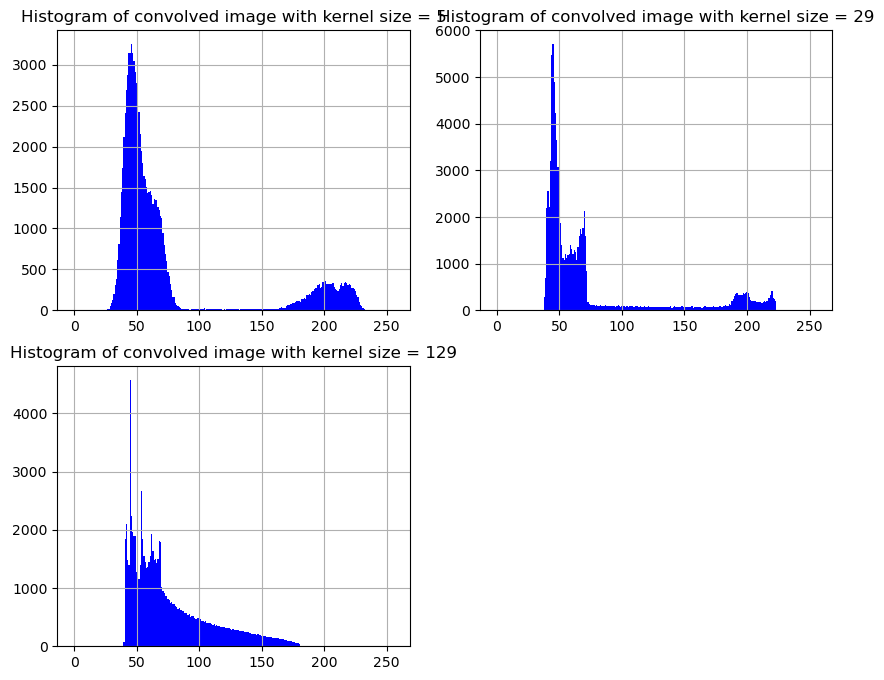

In [49]:
plt.figure(figsize=(10,8))
for i,hist_array in enumerate(hists):
    plt.subplot(2,2,i+1)
    hist, bins=np.histogram(hist_array, bins=256, range=(0,256))
    plt.bar(bins[:-1], hist, width=1, color='blue')
    plt.grid(True)
    plt.title(f"Histogram of convolved image with kernel size = {kernel_sizes[i]}")
plt.show()

###  Upsample grayscale image by a given scale using bilinear interpolation.

In [ ]:
def bilinear_resize(img, scale=2): 
    H, W = img.shape # Get the dimension of the image
    new_H, new_W = int(H * scale), int(W * scale) #Get the new dimension after scaling
    upsampled = np.zeros((new_H, new_W), dtype=img.dtype) #Creating an emtpy array or container to replace with the values after upsampling

    for i, j in itertools.product(range(new_H), range(new_W)): #Loop over every pixel in the upsampled image
        # Map output pixel (i, j) back to floating-point coordinates in the input image
        x = i / scale #eg upsampled (1,1)-> (0.5, 0.5) in original image
        y = j / scale

        x0, y0 = int(np.floor(x)), int(np.floor(y)) # Find the top-left corner pixel (x0, y0) in the original image
        x1, y1 = min(x0 + 1, H - 1), min(y0 + 1, W - 1) # Find the neighboring pixel to the right (y1) and below (x1) and clamp them to image boundaries to avoid going out of range

        dx, dy = x - x0, y - y0 # Compute distances from the top-left pixel (fractional part)

        # Get the intensities of the four corners(Neighbours) 
        Ia = img[x0, y0] #Intensity of top left in the original image
        Ib = img[x0, y1] #Top right
        Ic = img[x1, y0] #Bottom left
        Id = img[x1, y1] # Bottom right
        #Compute bilinear interpolation. Weighted sum of the four neighbours based on distances (dx,dy)
        upsampled[i, j] = (Ia * (1 - dx) * (1 - dy) +  #Weight for top left intensity
                            Ib * (1 - dx) * dy + #Weight for top right intensity
                            Ic * dx * (1 - dy) + #Weight for bottom left intensity
                            Id * dx * dy) #Weight for bottom right intensity
    return upsampled


In [45]:
def rotate_image(img, theta):
    H, W = img.shape # Get the dimension of the image
    rotated = np.zeros_like(img) #Create a container of 0s. 

    cx, cy = H // 2, W // 2 #Find the center of the original image
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    for i, j in itertools.product(range(H), range(W)):
        a1 = (i - cx) * cos_t + (j - cy) * sin_t + cx # Gives the x-co-ordinate of the rotated image by theta in counter-clockwise direction
        a2 = -(i - cx) * sin_t + (j - cy) * cos_t + cy # Gives the y-co-ordinate of the rotated image by theta in counter-clockwise direction

        if 0 <= a1 < H - 1 and 0 <= a2 < W - 1: # To make sure cordinates do not go out of the image
            x0, y0 = int(np.floor(a1)), int(np.floor(a2)) #Get the top-left cordinate
            x1, y1 = x0 + 1, y0 + 1 #Get the bottom right cordinates

            dx, dy = a1 - x0, a2- y0 # Get the distances of x and y-cordinates b/w cordinate we got after rotation and its top-left corner. 

            Ia = img[x0, y0]    #Get the intensity of the top-left in the original image
            Ib = img[x0, y1]    #Get the intensity of the top-right in the original image
            Ic = img[x1, y0]    #Get the intensity of the bottom-left in the original image
            Id = img[x1, y1]    #Get the intensity of the bottom-right in the original image
        #Now compute bilinear interpolation. Weighted sum of the four neighbours based on distances (dx,dy)
            rotated[i, j] = (Ia * (1 - dx) * (1 - dy) +  #Weight for top left intensity
                            Ib * (1 - dx) * dy + #Weight for top right intensity
                            Ic * dx * (1 - dy) + #Weight for bottom left intensity
                            Id * dx * dy) #Weight for bottom right intensity
    return rotated.astype(img.dtype)

In [ ]:
img = np.array(flowers) 
upsampled_a = bilinear_resize(img, scale=2)m
rotated_a = rotate_image(upsampled_a, np.deg2rad(45))

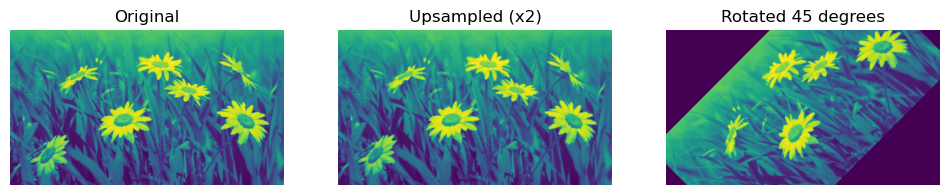

In [61]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(upsampled_a); plt.title("Upsampled (x2)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(rotated_a); plt.title("Rotated 45 degrees"); plt.axis("off")
plt.show()

In [62]:
print(f"Shape of the original image is {img.shape}")
print(f"Shape of the upsampled image is {upsampled_a.shape}")
print(f"Shape of the rotated image is {rotated_a.shape}")


Shape of the original image is (227, 400)
Shape of the upsampled image is (454, 800)
Shape of the rotated image is (454, 800)


### b. Rotate and upsample the image

In [63]:
rotated_b = rotate_image(img,theta=np.pi/4)
upsampled_b = bilinear_resize(rotated_b,2)

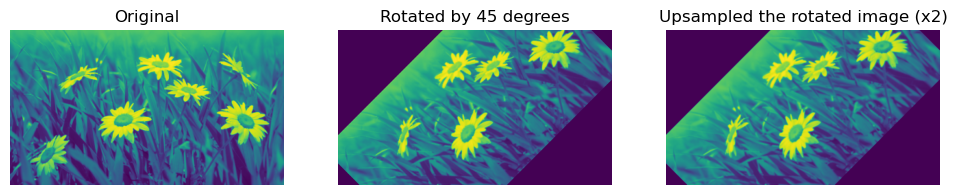

In [64]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(rotated_b); plt.title("Rotated by 45 degrees"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(upsampled_b); plt.title("Upsampled the rotated image (x2)"); plt.axis("off")
plt.show()

### Compute the difference b/w the images we finally got in part a and part b

In [76]:
diff = rotated_a-upsampled_b
print(f"The minimum of the difference is {np.min(diff):.2f} and the maximum of the diff is {np.max(diff):.2f}")

The minimum of the difference is 0.00 and the maximum of the diff is 255.00


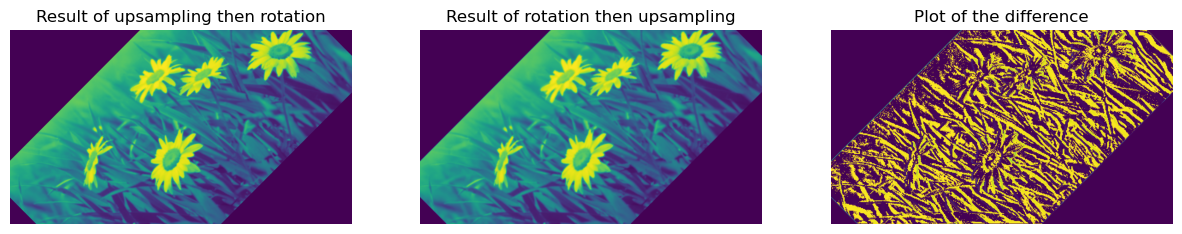

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(rotated_a)
plt.title("Result of upsampling then rotation")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(upsampled_b)
plt.title("Result of rotation then upsampling")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(diff, vmin=0, vmax=255)
plt.axis('off')
plt.title("Plot of the difference")
plt.show()

## 3. Image Sharpening

In [50]:
study_array = np.array(study)
study_array.shape

(373, 560)

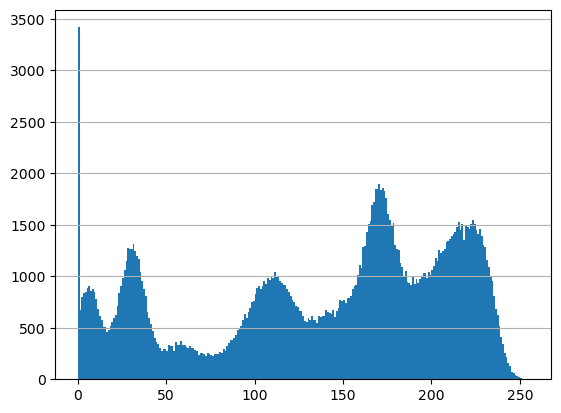

In [51]:
plt.hist(study_array.ravel(),bins = range(0,256))
plt.grid(axis='y')
plt.show()

In [58]:
def convolve(image, kernel, **kargs):
    if isinstance(image, Image.Image):
        image = image.convert('L')
        image = np.array(image)
    elif image.ndim == 3:  # RGB as np array
        image = np.mean(image, axis=2).astype(np.float32) # Simply taking the mean of values of channels

    conv_image = cv2.filter2D(image, -1, kernel)
    return conv_image.astype(np.float32)

In [97]:
def sharpenAdjust(img, p, sigma):
    img = img.convert('L') # Convert to grayscale
    img = np.array(img, dtype=np.float32) #Convert to numpy array    
    gauss_blurred =  gaussian(img,sigma, preserve_range=True)
    sharp = (1 + p) * img - p * gauss_blurred
    sharp = np.clip(sharp, 0, 255).astype(np.uint8)
    return sharp


In [138]:
P = [0,0.5, 1]

In [139]:
rajesh = Image.open("rajesh.png")

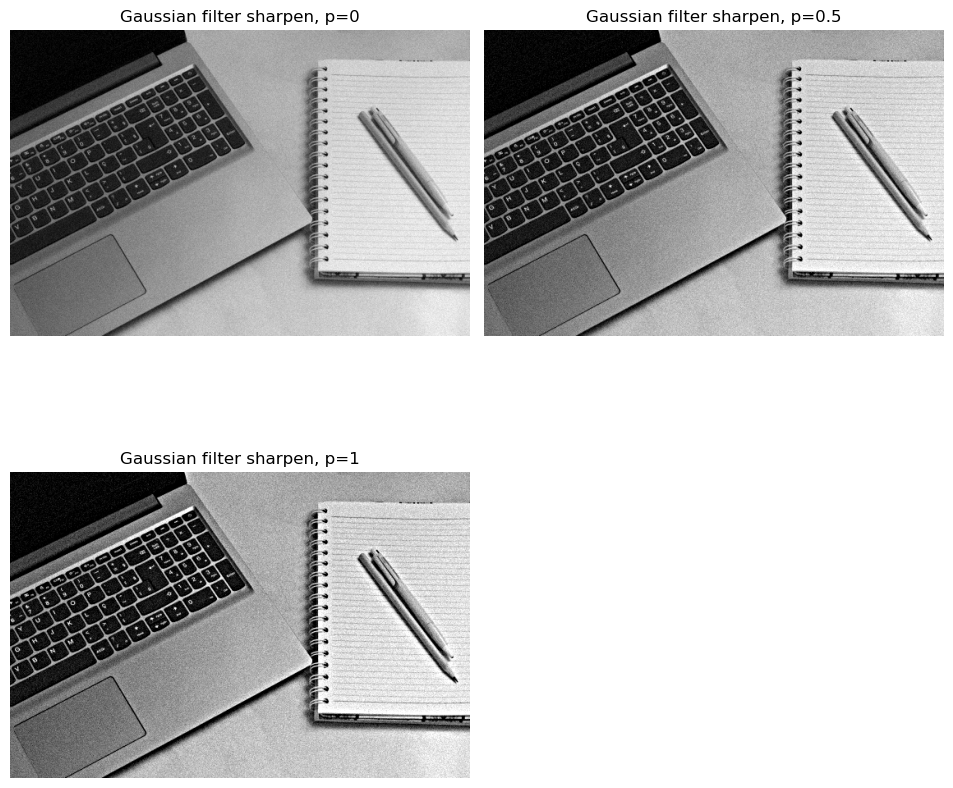

In [141]:
plt.figure(figsize=(10,10))
for i, p in enumerate(P):
    gauss_sharp = sharpenAdjust(study, p, 5)
    plt.subplot(2,2,i+1)
    plt.imshow(gauss_sharp, cmap='gray')
    plt.title(f'Gaussian filter sharpen, p={p}')
    plt.tight_layout()
    plt.axis('off')
plt.show()
